In [3]:
import torch
import os
import cv2
import random
import numpy as np
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

In [4]:
def set_seed(seed=1):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
set_seed(1)

RGB 是我们接触最多的颜色空间，由三个通道表示一幅图像，分别为红色(R)，绿色(G)和蓝色(B)。这三种颜色的不同组合可以形成几乎所有的其他颜色。



RGB 颜色空间是图像处理中最基本、最常用、面向硬件的颜色空间，比较容易理解。

RGB 颜色空间利用三个颜色分量的线性组合来表示颜色，任何颜色都与这三个分量有关，而且这三个分量是高度相关的，所以连续变换颜色时并不直观，想对

图像的颜色进行调整需要更改这三个分量才行。


自然环境下获取的图像容易受自然光照、遮挡和阴影等情况的影响，即对亮度比较敏感。而 RGB 颜色空间的三个分量都与亮度密切相关，即只要亮度改变，

三个分量都会随之相应地改变，而没有一种更直观的方式来表达。

RGB颜色空间的主要缺点是不直观，从R、G、B的值中很难知道该值所代表颜色的认知属性，因此RGB颜色空间不符合人对颜色的感知心理。另外，RGB颜色空

间是最不均匀的颜色空间之一，两种颜色之间的知觉差异不能采用该颜色空间中两个颜色点之间的距离来表示

## 1. 图像基本操作

(449, 500)


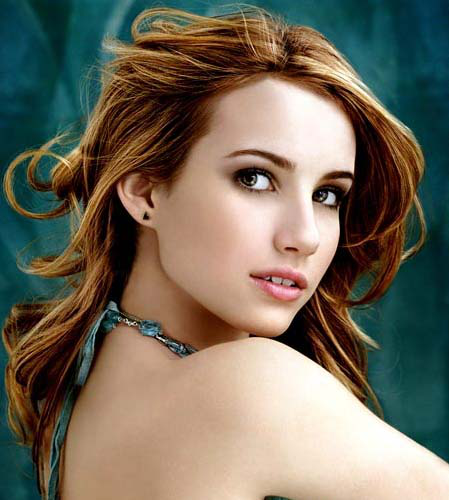

In [28]:
imgpath = "/home/bruce/Downloads/nms.jpg"
img = Image.open(imgpath)
print(img.size)
img

In [11]:
img_c = cv2.imread(imgpath)
cv2.rectangle(img_c, (123, 46), (345, 351), (0, 255, 0), 4)
cv2.namedWindow('image')
cv2.imshow('image', img_c)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imwrite("girl.jpg", img_c)

True

### 1.1 图像转换

-52 51 -28 37
450 491
(449, 490)


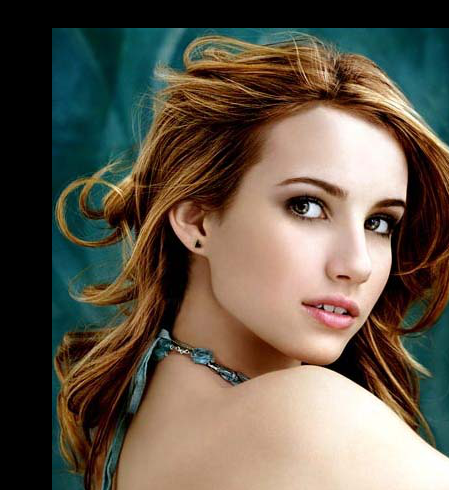

In [8]:
w, h = img.size
jitter = 0.2
dw = int(w*jitter)
dh = int(h*jitter)

pl = np.random.randint(-dw, dw)
pr = np.random.randint(-dw, dw)
pt = np.random.randint(-dh, dh)
pb = np.random.randint(-dh, dh)

# scaled width, scaled height
sw = w - pl - pr
sh = h - pt - pb
print(pl, pr, pt, pb)
print(sw, sh)
crop_img = img.crop((pl, pt, sw + pl - 1, sh + pt - 1))
print(crop_img.size)
crop_img

### 1.2 针对目标检测框的图像处理算法

In [12]:
im_data = Image.open(imgpath)
boxes = np.array([[123, 46, 345, 351]])
boxes_ = np.copy(boxes).astype(np.float32)
np.random.seed(3)
def random_scale_translation(img, boxes, jitter=0.2):
    """

    Arguments:
    img -- PIL.Image
    boxes -- numpy array of shape (N, 4) N is number of boxes
    factor -- max scale size
    im_info -- dictionary {width:, height:}

    Returns:
    im_data -- numpy.ndarray
    boxes -- numpy array of shape (N, 4)
    """

    w, h = img.size

    dw = int(w*jitter)
    dh = int(h*jitter)

    pl = np.random.randint(-dw, dw)
    pr = np.random.randint(-dw, dw)
    pt = np.random.randint(-dh, dh)
    pb = np.random.randint(-dh, dh)

    # scaled width, scaled height
    sw = w - pl - pr
    sh = h - pt - pb

    # 经过转换之后,图像大小变成 w - pr - 1, h - pb - 1
    cropped = img.crop((pl, pt, pl + sw - 1, pt + sh - 1))
    # boxes = [ 155, 96, 350, 269]
    # update boxes accordingly
    boxes[:, 0::2] -= pl
    boxes[:, 1::2] -= pt

    # clamp boxes
    boxes[:, 0::2] = boxes[:, 0::2].clip(0, sw-1)
    boxes[:, 1::2] = boxes[:, 1::2].clip(0, sh-1)

    # if flip
    if np.random.randint(2):
        cropped = cropped.transpose(Image.FLIP_LEFT_RIGHT)
        boxes[:, 0::2] = (sw-1) - boxes[:, 2::-2]

    return cropped, boxes


def imshow1():
    img_c = cv2.imread(imgpath)
    cv2.rectangle(img_c, (123, 46), (345, 351), (0, 255, 0), 4)
    cv2.namedWindow('image')
    cv2.imshow('image', img_c)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

img_t, boxes_t = random_scale_translation(im_data.copy(),
                                          boxes.copy(),
                                          jitter=0.2)

imgcv = cv2.cvtColor(np.asarray(img_t), cv2.COLOR_RGB2BGR)

print(boxes_t)
index1 = tuple(boxes_t[:, 0:2][0])
index2 = tuple(boxes_t[:, 2:4][0])
cv2.rectangle(imgcv, index1, index2, (0, 255, 0), 4)
cv2.namedWindow('imag_')
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imwrite("girl1.jpg", imgcv)

[[106  15 328 320]]


True

### 1.3基本操作值归一化

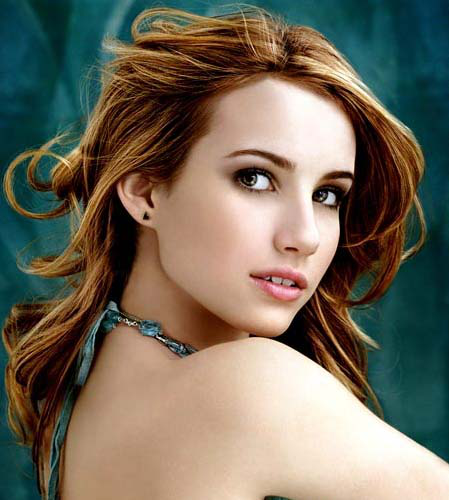

In [13]:
transform = transforms.Compose([transforms.ToTensor(),  # Convert a ``PIL Image`` or ``numpy.ndarray`` to tensor
                               transforms.ToPILImage()])  # Convert a tensor or an ndarray to PIL Image.
new_img = transform(img)
new_img

In [14]:
type(new_img)

PIL.Image.Image

In [15]:
img.mode

'RGB'

### 1.4 图像尺寸定义 Resize

(224, 224)


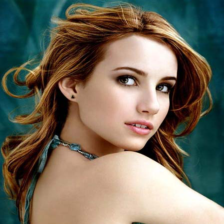

In [137]:
transform = transforms.Compose([transforms.Resize((224, 224)),
                               transforms.ToTensor(),
                               transforms.ToPILImage()])
re_img = transform(img)
print(re_img.size)
re_img

### 1.5 图片进行尺度缩放

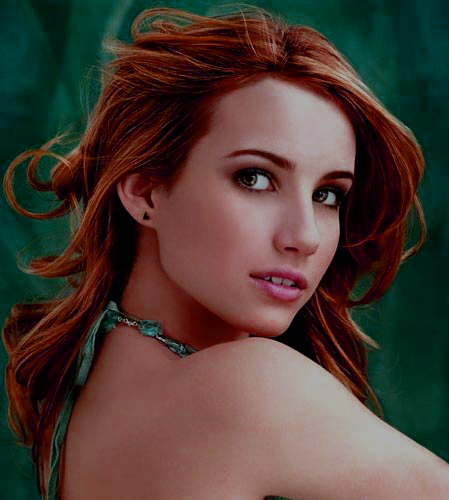

In [19]:
def rand_scale(s):
    scale = np.random.uniform(1, s)
    if np.random.randint(1, 10000) % 2:
        return scale
    return 1./scale

def random_distort(img, hue=.1, sat=1.5, val=1.5):

    hue = np.random.uniform(-hue, hue)
    sat = rand_scale(sat)
    val = rand_scale(val)

    img = img.convert('HSV')
    cs = list(img.split())
    cs[1] = cs[1].point(lambda i: i * sat)
    cs[2] = cs[2].point(lambda i: i * val)

    def change_hue(x):
        x += hue * 255
        if x > 255:
            x -= 255
        if x < 0:
            x += 255
        return x

    cs[0] = cs[0].point(change_hue)
    img = Image.merge(img.mode, tuple(cs))

    img = img.convert('RGB')
    return img

random_distort(img)

In [27]:
np.random.uniform(-1.5, 1.5)

0.7729957352648995

## 2.图像裁剪

### 2.1 图像随机裁剪 RandomCrop

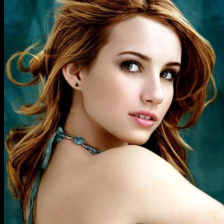

In [216]:
transform = transforms.Compose([
    transforms.Resize(224),  # 先缩放到224, 然后进行随机裁剪,上下左右填充值为0, 然后再随机裁剪
    transforms.RandomCrop(224, padding=4),
    transforms.ToTensor(),  # 归一化操作
    transforms.ToPILImage()])
randomClipImg = transform(img)
randomClipImg

### 2.2 中心裁剪 centerCrop

(224, 224)


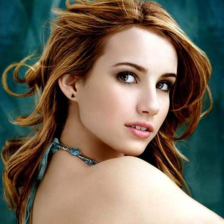

In [217]:
transform = transforms.Compose([transforms.Resize(224),  # 先缩放到224, 然后进行随机裁剪,上下左右填充值为0, 然后再随机裁剪
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),  # 归一化操作
                               transforms.ToPILImage()])
centerClipImg = transform(img)
print(centerClipImg.size)
centerClipImg


### 2.3 随机长宽比裁剪 RandomResizedCrop
#### 随机长宽比裁剪原始图片,将图片设定到size

(224, 224)


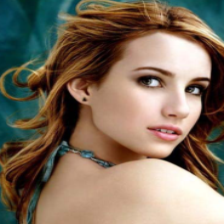

In [218]:
transform = transforms.Compose([transforms.Resize(224),  # 先缩放到224, 然后进行随机裁剪,上下左右填充值为0, 然后再随机裁剪
                               transforms.RandomResizedCrop(224),
                               transforms.ToTensor(),  # 归一化操作
                               transforms.ToPILImage()])
centerClipImg = transform(img)
print(centerClipImg.size)
centerClipImg

### 2.4 FiveCrop 
#### 上下左右中心裁剪,返回的的是5个裁剪后的图片

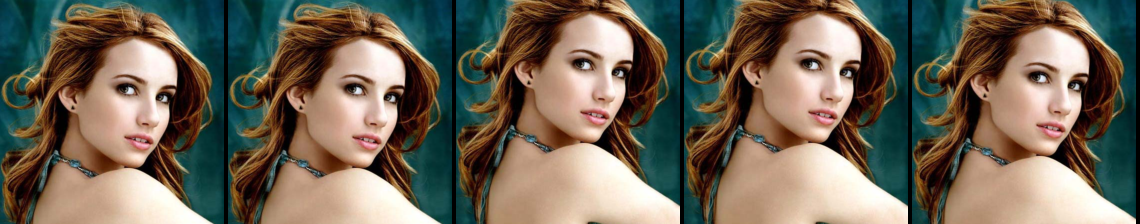

In [219]:
transform = transforms.Compose([
    transforms.Resize(224),  # 先对原始图片进行缩放,缩放到224尺寸,然后再进行裁剪即可
    transforms.FiveCrop(224),
                               ])
ClipImg = transform(img)
delta = 20
top_right = 0
UNIT_SIZE=224
new_img_2 = Image.new("RGB", (UNIT_SIZE*5+delta, 224))
for im in ClipImg:
    new_img_2.paste(im, (top_right, 0)) # 将image复制到target的指定位置中
    top_right += UNIT_SIZE + int(delta/5) # 左上角的坐标，因为是横向的图片，所以只需要 x 轴的值变化就行
new_img_2

### 2.5 上下左右中心裁剪后翻转 TenCrop
#### 对图片进行上下左右中心裁剪,然后全部翻转(水平或者是垂直)一共返回10张图片

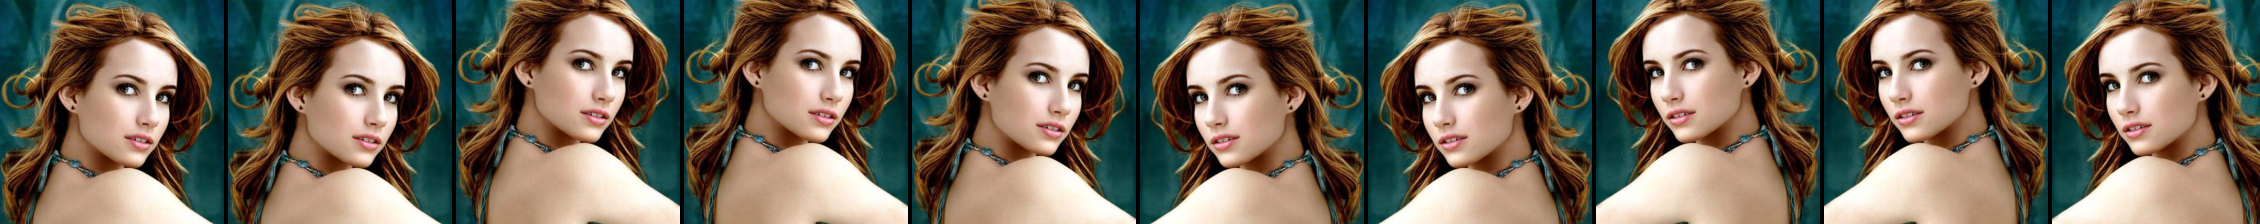

In [220]:
transform = transforms.Compose([
    transforms.Resize(224),  # 先对原始图片进行缩放,缩放到224尺寸,然后再进行裁剪即可
    transforms.TenCrop(224),
                               ])
ClipImg = transform(img)
delta = 20
top_right = 0
UNIT_SIZE=224
new_img_2 = Image.new("RGB", (UNIT_SIZE*10+delta, 224))
for im in ClipImg:
    new_img_2.paste(im, (top_right, 0)) # 将image复制到target的指定位置中
    top_right += UNIT_SIZE + int(delta/5) # 左上角的坐标，因为是横向的图片，所以只需要 x 轴的值变化就行
new_img_2

## 3. 图像翻转和旋转

### 3.1 依概率水平翻转
#### 依据概率p对PIL图片进行水平翻转, p默认的值是0.5

(224, 249)


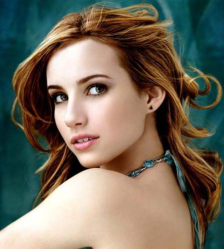

In [221]:
transform = transforms.Compose([transforms.Resize(224),  # 先缩放到224, 然后进行随机裁剪,上下左右填充值为0, 然后再随机裁剪
                               transforms.RandomHorizontalFlip(p=0.9),
                               transforms.ToTensor(),  # 归一化操作
                               transforms.ToPILImage()])
pFlipImg = transform(img)
print(pFlipImg.size)
pFlipImg

### 3.2 依概率垂直翻转
#### 依据概率p对PIL图片进行垂直翻转, p默认的值是0.5

(224, 224)


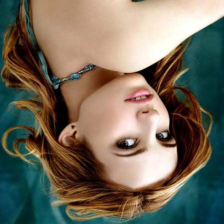

In [223]:
transform = transforms.Compose([
    # 先缩放到224, 然后进行随机裁剪,上下左右填充值为0, 然后再随机裁剪,如果是一个数224, 那么其实按照比例来缩放,不是224x224,是224x250
    transforms.Resize((224, 224)),  
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),  # 归一化操作
    transforms.ToPILImage()])
pFlipImg = transform(img)
print(pFlipImg.size)
pFlipImg

### 3.3随机旋转 RandomRotation
#### 依照参数degrees 随机旋转一个角度

(224, 249)


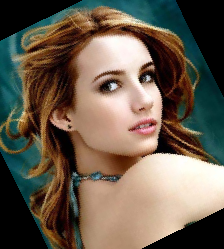

In [224]:
transform = transforms.Compose([
    transforms.Resize(224),  
    transforms.RandomRotation(30),  # 表示在-30 ~ 30 之间随机旋转,如果是(30, 60)表示在此区间随机旋转
    transforms.ToTensor(),  # 归一化操作
    transforms.ToPILImage()])

pFlipImg = transform(img)
print(pFlipImg.size)
pFlipImg

## 4.图像变换

### 4.1标准化 Normalize
#### 对数据按照通道进行标准化,就是先减去均值,再除以标准差, 需要先归一化

(224, 249)


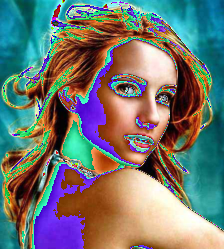

In [243]:
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),  # 归一化操作在前
    transforms.Normalize(mean, std),  # 均值, 方差
    transforms.ToPILImage()
])

pFlipImg = transform(img)
print(pFlipImg.size)
pFlipImg

### 4.2 填充 Pad
#### 对图像进行填充

(232, 289)


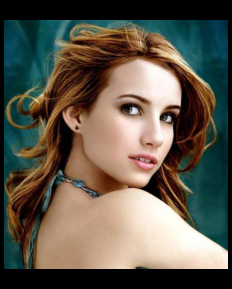

In [269]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.Pad((4, 20), padding_mode="constant"),  # 均值, 方差, pad_mode: edge, reflect, symmetric
    transforms.ToTensor(),  # 归一化操作在前
    transforms.ToPILImage()
])

pFlipImg = transform(img)
print(pFlipImg.size)
pFlipImg

### 4.3 线性变换 LinearTransformation
#### 主要用于白化处理

### 4.4 修改亮度,对比度和饱和度 ColorJitter

(224, 224)


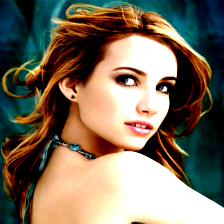

In [301]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.6, contrast=0.8, saturation=0, hue=0),
    transforms.ToTensor(),  # 归一化操作
    transforms.ToPILImage()
])

pFlipImg = transform(img)
print(pFlipImg.size)
pFlipImg

### 4.5 转换为灰度图 Grayscale
#### 将图片转化为灰度图

(224, 249)


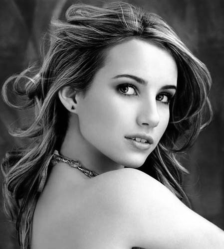

In [314]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.Grayscale(1),  # 1为正常的灰度图,3表示3个通道是一样的
    transforms.ToTensor(),  # 归一化操作在前
    transforms.ToPILImage()
])

pFlipImg = transform(img)
print(pFlipImg.size)
pFlipImg

### 4.6 仿射变换
#### 保持图像中心不变的随机仿射变换

(224, 249)


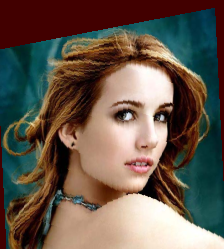

In [324]:
transform = transforms.Compose([
    transforms.Resize(224),
    # 旋转角度,水平垂直偏移距离,缩放因子
    transforms.RandomAffine(degrees=30, translate=(0, 0.2), scale=(0.9, 1),shear=(6, 9), fillcolor=66),
    transforms.ToTensor(),  # 归一化操作在前
    transforms.Normalize(mean, std),  # 均值, 方差

    transforms.ToPILImage()
])

pFlipImg = transform(img)
print(pFlipImg.size)
pFlipImg

In [ ]:
### 4.7 依概率p转为灰度图RandomGrayscale

(224, 249)


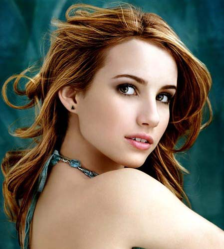

In [329]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomGrayscale(p=0.6),
    transforms.ColorJitter(brightness=0.6, contrast=0.8, saturation=0, hue=0),

    transforms.ToTensor(),  # 归一化操作在前
    transforms.ToPILImage()
])

pFlipImg = transform(img)
print(pFlipImg.size)
pFlipImg

### example

(224, 249)


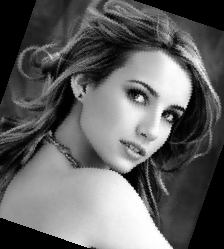

In [334]:
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomRotation(30),  # 表示在-30 ~ 30 之间随机旋转,如果是(30, 60)表示在此区间随机旋转

    transforms.RandomGrayscale(p=0.8),
    transforms.ToTensor(),  # 归一化操作在前
    transforms.ToPILImage()
])

pFlipImg = transform(img)
print(pFlipImg.size)
pFlipImg

In [1]:
a = [1,2,3]
a[-2:]

[2, 3]